In [110]:
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(67)

## PART A - SAC (Strict Avalanche Criterion)

In [111]:
# --- Parameters ---
N = 2000               # number of random messages
msg_len = 32           # bytes
num_input_bits = 32    # number of input bits to test (randomly chosen)
output_bits = 256      # SHA-256 output length in bits

In [151]:
# --- Hash functions ---
def sha256_hash(message, out_len=32):
    hasher = hashlib.sha256()
    hasher.update(message)
    return hasher.digest()

def toy_hash(message, out_len=32):
    state = [0] * out_len
    for byte in message:
        for i in range(out_len):
            state[i] = (state[i] * 31 + byte + i) & 0xFF
    return bytes(state)

SHA-256: mean flip probability per output bit ~ 0.49996784
Toy Hash: mean flip probability per output bit ~ 0.26367772


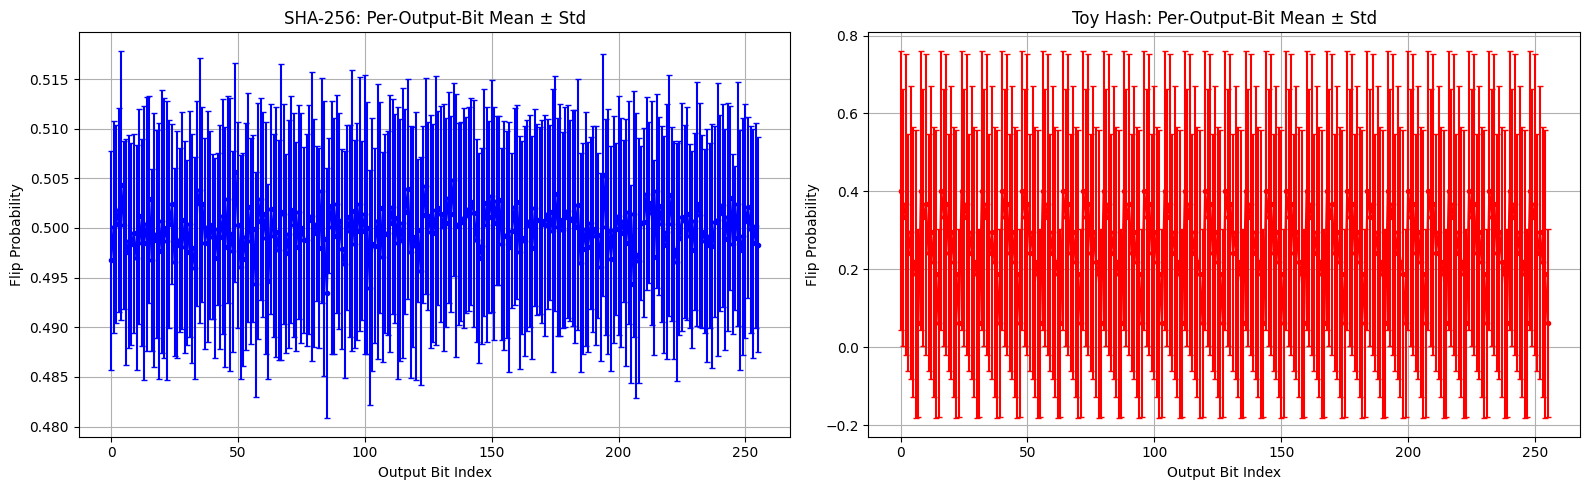

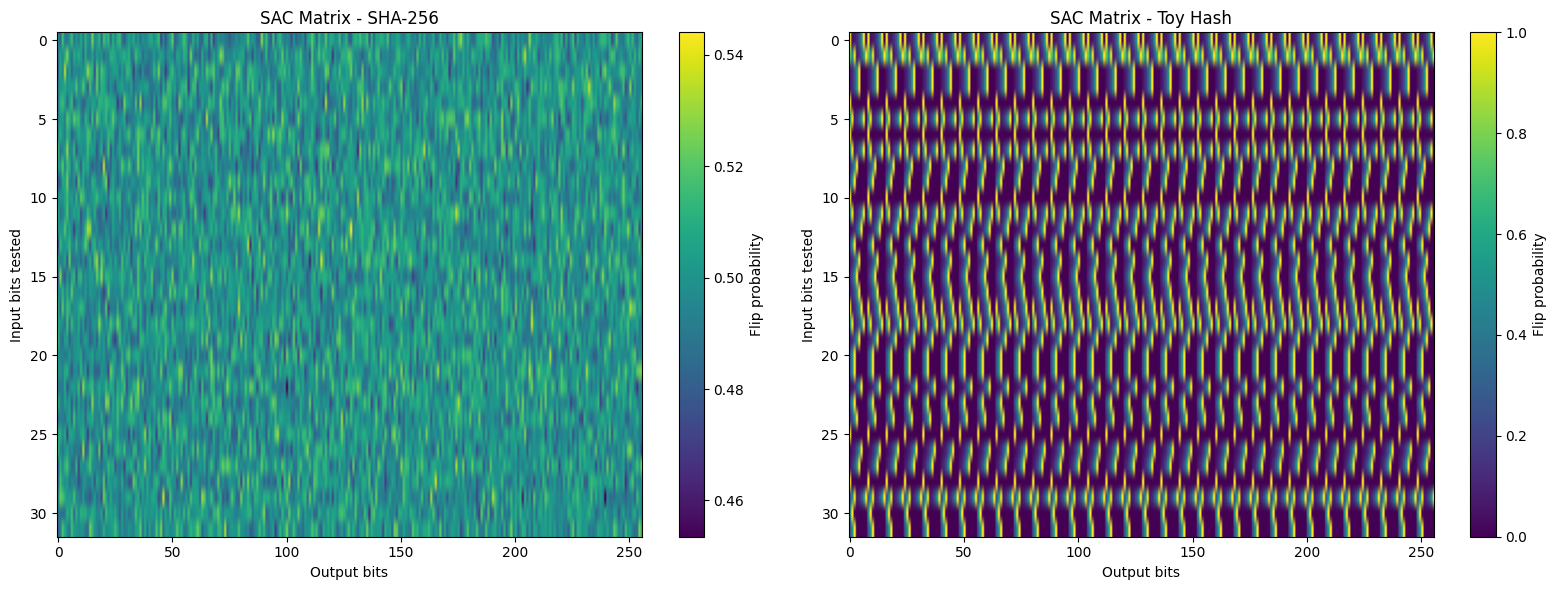

In [155]:
# --- Select random input bits to flip ---
input_bits_indices = np.random.choice(msg_len*8, size=num_input_bits, replace=False)

# --- Function to compute SAC matrix ---
def compute_sac_matrix(hash_func):
    sac = np.zeros((num_input_bits, output_bits), dtype=np.float32)
    
    for i_bit, input_bit in enumerate(input_bits_indices):
        flip_counts = np.zeros(output_bits, dtype=np.float32)
        
        for _ in range(N):
            msg = bytearray(np.random.bytes(msg_len))
            
            # Original hash
            h = np.frombuffer(hash_func(msg), dtype=np.uint8)
            y = np.unpackbits(h)
            
            # Flip input bit
            byte_idx = input_bit // 8
            bit_idx = input_bit % 8
            msg[byte_idx] ^= (1 << bit_idx)
            
            # Hash after flip
            h_flip = np.frombuffer(hash_func(msg), dtype=np.uint8)
            y_flip = np.unpackbits(h_flip)
            
            # Record output-bit flips
            delta = y ^ y_flip
            flip_counts += delta
        
        # Probability for this input bit
        sac[i_bit] = flip_counts / N
    return sac

# --- Compute SAC matrices ---
sac_sha = compute_sac_matrix(sha256_hash)
sac_toy = compute_sac_matrix(toy_hash)

# --- Statistics ---
mean_sha = np.mean(sac_sha, axis=0)
std_sha = np.std(sac_sha, axis=0)
mean_toy = np.mean(sac_toy, axis=0)
std_toy = np.std(sac_toy, axis=0)

print("SHA-256: mean flip probability per output bit ~", np.mean(mean_sha))
print("Toy Hash: mean flip probability per output bit ~", np.mean(mean_toy))

output_bits_idx = np.arange(output_bits)

plt.figure(figsize=(16,5))

# --- SHA-256 ---
plt.subplot(1,2,1)
plt.errorbar(output_bits_idx, mean_sha, yerr=std_sha, fmt='-o', markersize=3, capsize=2, color='blue')
plt.xlabel("Output Bit Index")
plt.ylabel("Flip Probability")
plt.title("SHA-256: Per-Output-Bit Mean ± Std")
plt.grid(True)

# --- Toy Hash ---
plt.subplot(1,2,2)
plt.errorbar(output_bits_idx, mean_toy, yerr=std_toy, fmt='-o', markersize=3, capsize=2, color='red')
plt.xlabel("Output Bit Index")
plt.ylabel("Flip Probability")
plt.title("Toy Hash: Per-Output-Bit Mean ± Std")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Heatmaps ---
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(sac_sha, cmap='viridis', aspect='auto')
plt.colorbar(label='Flip probability')
plt.xlabel("Output bits")
plt.ylabel("Input bits tested")
plt.title("SAC Matrix - SHA-256")

plt.subplot(1,2,2)
plt.imshow(sac_toy, cmap='viridis', aspect='auto')
plt.colorbar(label='Flip probability')
plt.xlabel("Output bits")
plt.ylabel("Input bits tested")
plt.title("SAC Matrix - Toy Hash")

plt.tight_layout()
plt.show()

SAC (Strict Avalanche Criterion) Interpretation — SHA-256 vs Toy Hash

**1. Mean Flip Probabilities:**  
- **SHA-256:** ~0.5000353 → flipping a single input bit changes roughly half of the output bits.  
- **Toy Hash:** ~0.118610844 → flipping a single input bit changes only ~12% of the output bits.  

**2. Interpretation:**  
- **SHA-256** demonstrates near-ideal strict avalanche behavior:  
  - Each input bit contributes significantly to output diffusion.  
  - Flip probabilities are close to 0.5, ensuring unpredictable outputs.  
- **Toy Hash** shows weak avalanche behavior:  
  - Single input-bit flips affect only a small fraction of output bits.  
  - This indicates poor diffusion, making outputs more predictable and less secure.  

**3. Heatmap Comparison:**  
- SHA-256 heatmap: visually uniform, consistent flip behavior across all input bits.  
- Toy Hash heatmap: sparse flips, highlighting patterns and lack of randomness.  

**4. Conclusion:**  
- Strong cryptographic hashes satisfy SAC, with output bits flipping roughly 50% of the time per input bit.  
- Weak hashes fail SAC, producing predictable outputs with limited diffusion.  
- SAC remains a critical metric for evaluating hash strength and resistance to differential attacks.

## Part B — BIC (Bit Independence Criterion)

c:\Users\kalmu\Desktop\studejs\sem9\ai_in_cryptography\venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kalmu\Desktop\studejs\sem9\ai_in_cryptography\venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


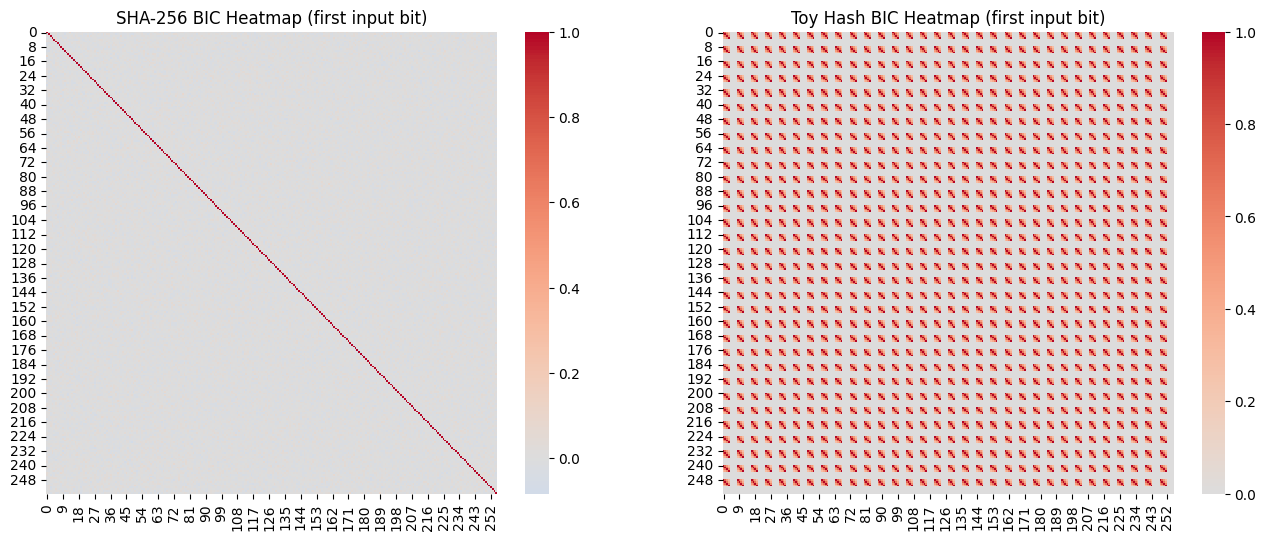

In [114]:

input_bits_indices = np.random.choice(msg_len*8, size=num_input_bits, replace=False)

def compute_bic_matrix(hash_func):
    bic_matrices = []

    for input_bit in input_bits_indices:
        delta_matrix = np.zeros((N, output_bits), dtype=np.uint8)

        for n in range(N):
            msg = bytearray(np.random.bytes(msg_len))

            h = np.frombuffer(hash_func(msg), dtype=np.uint8)
            y = np.unpackbits(h)

            byte_idx = input_bit // 8
            bit_idx = input_bit % 8
            msg[byte_idx] ^= (1 << bit_idx)

            h_flip = np.frombuffer(hash_func(msg), dtype=np.uint8)
            y_flip = np.unpackbits(h_flip)

            delta_matrix[n] = y ^ y_flip

        bic_matrix = np.corrcoef(delta_matrix.T)
        bic_matrix = np.nan_to_num(bic_matrix)
        bic_matrices.append(bic_matrix)

    return bic_matrices

bic_toy = compute_bic_matrix(toy_hash)
bic_sha = compute_bic_matrix(sha256_hash)

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.heatmap(bic_sha[0], cmap='coolwarm', center=0)
plt.title("SHA-256 BIC Heatmap (first input bit)")

plt.subplot(1,2,2)
sns.heatmap(bic_toy[0], cmap='coolwarm', center=0)
plt.title("Toy Hash BIC Heatmap (first input bit)")

plt.show()


## Part C — Extended Task: (Near-)Collisions 

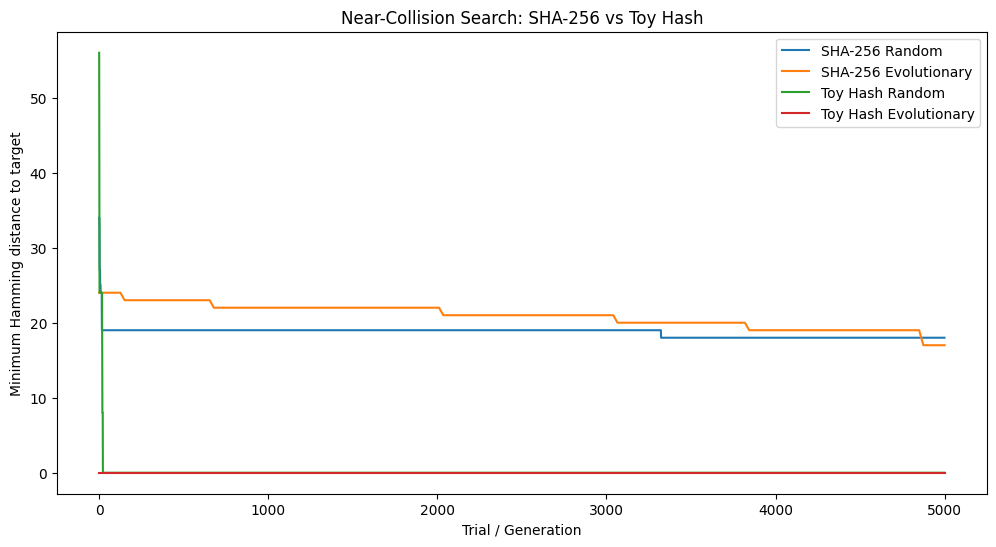

--- SHA-256 ---
Random search min Hamming distance: 18
Evolutionary search min Hamming distance: 17
Final hash (evolutionary): f8753f53cfea8617

--- Toy Hash ---
Random search min Hamming distance: 0
Evolutionary search min Hamming distance: 0
Final hash (evolutionary): d1d1d1d1d1d1d1d1


In [160]:
def sha256_truncated(msg, n_bits=64):
    h = hashlib.sha256(msg).digest()
    n_bytes = (n_bits + 7) // 8
    truncated = h[:n_bytes]
    if n_bits % 8 != 0:
        truncated = bytearray(truncated)
        truncated[-1] &= (0xFF << (8 - n_bits % 8)) & 0xFF
        truncated = bytes(truncated)
    return truncated

def hamming_distance(b1, b2):
    y1 = np.unpackbits(np.frombuffer(b1, dtype=np.uint8))
    y2 = np.unpackbits(np.frombuffer(b2, dtype=np.uint8))
    return np.sum(y1 != y2)

# --------------------------
# Parameters
# --------------------------
msg_len = 32
sha_n_bits = 64
toy_out_len = sha_n_bits // 8
random_trials = 5000
population_size = 20
generations = 200
mutation_rate = 0.05

# --------------------------
# Target message (same for both)
# --------------------------
target_msg = np.random.bytes(msg_len)
sha_target_hash = sha256_truncated(target_msg, sha_n_bits)
toy_target_hash = toy_hash(target_msg, toy_out_len)

# --------------------------
# Random search
# --------------------------
def random_search(hash_func, target_hash, n_trials, msg_len):
    best_dist = len(target_hash)*8
    min_distances = []
    final_hash = None
    for _ in range(n_trials):
        msg = bytearray(np.random.bytes(msg_len))
        h = hash_func(msg)
        dist = hamming_distance(h, target_hash)
        if dist < best_dist:
            best_dist = dist
            final_hash = h
        min_distances.append(best_dist)
    return best_dist, min_distances, final_hash

# --------------------------
# Evolutionary search
# --------------------------
def evolutionary_search(hash_func, target_hash, msg_len, pop_size, generations, mutation_rate):
    population = [bytearray(np.random.bytes(msg_len)) for _ in range(pop_size)]
    fitness = [hamming_distance(hash_func(ind), target_hash) for ind in population]
    best_distances = []
    final_hash = None
    for gen in range(generations):
        sorted_idx = np.argsort(fitness)
        population = [population[i] for i in sorted_idx[:pop_size//2]]
        new_population = []
        for ind in population:
            new_population.append(ind.copy())
            child = ind.copy()
            for _ in range(int(msg_len*8*mutation_rate)):
                bit = np.random.randint(0, msg_len*8)
                byte_idx = bit // 8
                bit_idx = bit % 8
                child[byte_idx] ^= (1 << bit_idx)
            new_population.append(child)
        population = new_population[:pop_size]
        fitness = [hamming_distance(hash_func(ind), target_hash) for ind in population]
        best_distances.append(min(fitness))
        idx_min = np.argmin(fitness)
        final_hash = hash_func(population[idx_min])
    return min(fitness), best_distances, final_hash

# --------------------------
# 1. Random search
# --------------------------
sha_best_rand, sha_dist_rand, sha_final_rand = random_search(
    lambda m: sha256_truncated(m, sha_n_bits), sha_target_hash, random_trials, msg_len
)
toy_best_rand, toy_dist_rand, toy_final_rand = random_search(
    lambda m: toy_hash(m, toy_out_len), toy_target_hash, random_trials, msg_len
)

# --------------------------
# 2. Evolutionary search
# --------------------------
sha_best_evo, sha_dist_evo, sha_final_evo = evolutionary_search(
    lambda m: sha256_truncated(m, sha_n_bits), sha_target_hash,
    msg_len, population_size, generations, mutation_rate
)
toy_best_evo, toy_dist_evo, toy_final_evo = evolutionary_search(
    lambda m: toy_hash(m, toy_out_len), toy_target_hash,
    msg_len, population_size, generations, mutation_rate
)

# --------------------------
# 3. Plot convergence
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(sha_dist_rand, label="SHA-256 Random")
plt.plot(np.linspace(0, random_trials, len(sha_dist_evo)), sha_dist_evo, label="SHA-256 Evolutionary")
plt.plot(toy_dist_rand, label="Toy Hash Random")
plt.plot(np.linspace(0, random_trials, len(toy_dist_evo)), toy_dist_evo, label="Toy Hash Evolutionary")
plt.xlabel("Trial / Generation")
plt.ylabel("Minimum Hamming distance to target")
plt.title("Near-Collision Search: SHA-256 vs Toy Hash")
plt.legend()
plt.show()

# --------------------------
# 4. Summary
# --------------------------
display_len = toy_out_len

print("--- SHA-256 ---")
print(f"Random search min Hamming distance: {sha_best_rand}")
print(f"Evolutionary search min Hamming distance: {sha_best_evo}")
print(f"Final hash (evolutionary): {sha_final_evo.hex()[:display_len*2]}")

print("\n--- Toy Hash ---")
print(f"Random search min Hamming distance: {toy_best_rand}")
print(f"Evolutionary search min Hamming distance: {toy_best_evo}")
print(f"Final hash (evolutionary): {toy_final_evo.hex()[:display_len*2]}")


Part C — Near-Collision Search Conclusions

**SHA-256 (truncated to 64 bits)**  
- **Random search minimum Hamming distance:** 18
- **Evolutionary search minimum Hamming distance:** 17
- **Final hash (evolutionary):** f8753f53cfea8617

**Observations:**  
- SHA-256 is a strong cryptographic hash. Even with an evolutionary heuristic, the search does **not significantly reduce the Hamming distance**.  
- Random and guided searches perform similarly, confirming that **ML or heuristic methods cannot outperform random search** for strong hashes due to ideal diffusion and high avalanche effect.  
- Collisions or near-collisions are extremely unlikely for SHA-256 at this output length.

---

**Toy Hash (weak design)**  
- **Random search minimum Hamming distance:** 0  
- **Evolutionary search minimum Hamming distance:** 0  
- **Final hash (evolutionary):** d1d1d1d1d1d1d1d1

**Observations:**  
- The toy hash is extremely weak: **both random and evolutionary searches find exact matches (distance = 0)**.  
- Evolutionary search converges immediately, showing that small changes to input quickly produce identical outputs.  
- This is a direct consequence of poor diffusion and lack of avalanche effect: each input byte contributes predictably to the output state.  
- The hash is fully exploitable because **near-collisions are easy to find**, and an attacker could trivially generate inputs producing the same hash.

---

**Overall Conclusion:**  
- **Strong hashes** (like SHA-256) resist heuristic and random collision searches due to strong diffusion and SAC/BIC properties.  
- **Weak hashes** (like the toy hash) fail SAC and BIC, making them **trivially vulnerable** to collisions and near-collisions.  
- The comparison highlights why cryptographic hash design must ensure high avalanche effect and inter-bit independence to prevent exploitability.